In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mmt_simulator as mmt
import scipy.fft as fft

import knn_mi_comp as mi 
import my_causation_entropy_builder as my_ceb
import wwt_tools as wwt

import pickle

%matplotlib inline 

Pi = np.pi

In [2]:
plt.rcParams.update({ "text.usetex": True, "font.family": "serif" })
font = {'size': 16}
matplotlib.rc('font', **font)

fmt = 'pdf'
weight_str = 'max_te_lag'

In [3]:
Nval = 2**11

inertialleft = 50
inertialright = 500

dt = 5e-3
ep_val = .5
alpha = .5
gamma = 2.

samp_rate = 40

dts = samp_rate * dt

tf = 5.*inertialright/ep_val**2.

Dxa = np.abs(np.concatenate((np.arange(Nval+1),np.arange(-Nval+1,0,1)),0)) # note, we never need a naked Dx
Dxalpha = Dxa**alpha   
    

print(tf)

10000.0


In [ ]:
reload = True
if reload:
  sol, sol0, hlinear, hnonlinear, tavg, tseries_short, tseries_mid, tseries = pickle.load(open("wwt_run_file.pkl", "rb"))
else:
  sol, sol0, hlinear, hnonlinear, tavg, tseries_short, tseries_mid, tseries = mmt.mmt_solver(Nval, tf, ep_val, dt, samp_rate, inertialright)
  pickle.dump([sol, sol0, hlinear, hnonlinear, tavg, tseries_short, tseries_mid, tseries], open("wwt_run_file.pkl", "wb"))


In [5]:
# We further reduce the sample rate of tseries because otherwise, we'll be here till the end of time
one_over_ep_dep = 10
dts *= one_over_ep_dep
tseries = tseries[:, ::one_over_ep_dep]
tseries_mid = tseries_mid[:, ::one_over_ep_dep]
tseries_short = tseries_short[:, ::one_over_ep_dep]

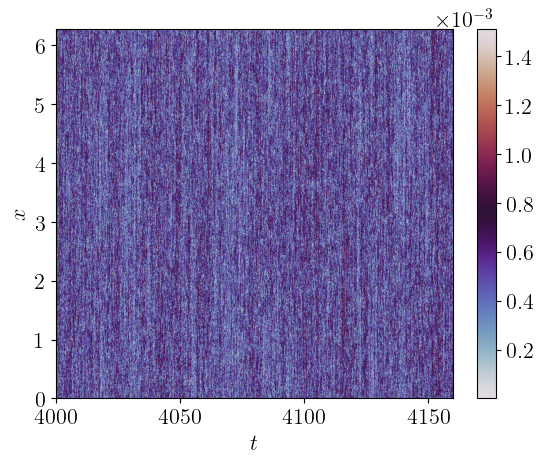

In [6]:
num_t_steps_for_plotting = 800
plt_scl_fac = 1
tvals = 2*inertialright/ep_val**2 + plt_scl_fac*40*dt*np.arange(int(num_t_steps_for_plotting/plt_scl_fac))
xvals = np.linspace(0,2.*np.pi,2*Nval)
fig, ax = plt.subplots()

# Plot the data with a colormap

#plt.contourf(tvals,xvals,np.abs(np.fft.ifft(tseries[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),levels=30)
im = ax.imshow(np.abs(np.fft.ifft(tseries[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),cmap='twilight',origin='lower',
                   extent=[tvals[0], tvals[-1], 0., 2.*np.pi], clip_on=True,aspect='auto')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")

cbar = fig.colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2e}'))
cbar.update_ticks()
plt.savefig("MMT_space_time_dynamics.pdf", dpi=150, bbox_inches='tight')  

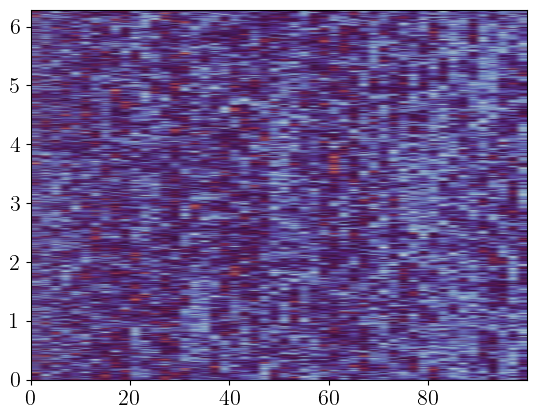

In [7]:
num_t_steps_for_plotting = 500
plt_scl_fac = 1
tvals = plt_scl_fac*40*dt*np.arange(int(num_t_steps_for_plotting/plt_scl_fac))
xvals = np.linspace(0,2.*np.pi,2*Nval)
fig, ax = plt.subplots()

# Plot the data with a colormap

#plt.contourf(tvals,xvals,np.abs(np.fft.ifft(tseries[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),levels=30)
im = ax.imshow(np.abs(np.fft.ifft(tseries_short[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),cmap='twilight',origin='lower',
                   extent=[tvals[0], tvals[-1], 0., 2.*np.pi], clip_on=True,aspect='auto')


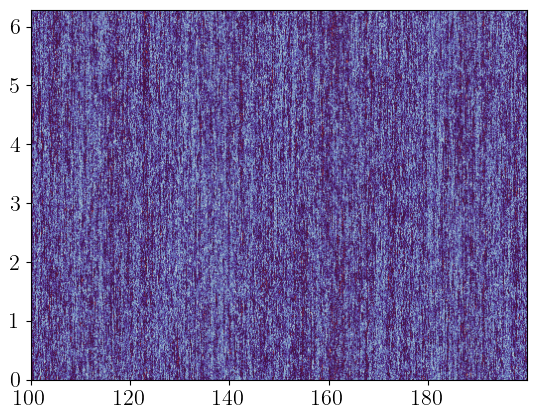

In [8]:
num_t_steps_for_plotting = 500
plt_scl_fac = 1
tvals = 100 + plt_scl_fac*40*dt*np.arange(int(num_t_steps_for_plotting/plt_scl_fac))
xvals = np.linspace(0,2.*np.pi,2*Nval)
fig, ax = plt.subplots()

# Plot the data with a colormap

#plt.contourf(tvals,xvals,np.abs(np.fft.ifft(tseries[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),levels=30)
im = ax.imshow(np.abs(np.fft.ifft(tseries_mid[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),cmap='twilight',origin='lower',
                   extent=[tvals[0], tvals[-1], 0., 2.*np.pi], clip_on=True,aspect='auto')


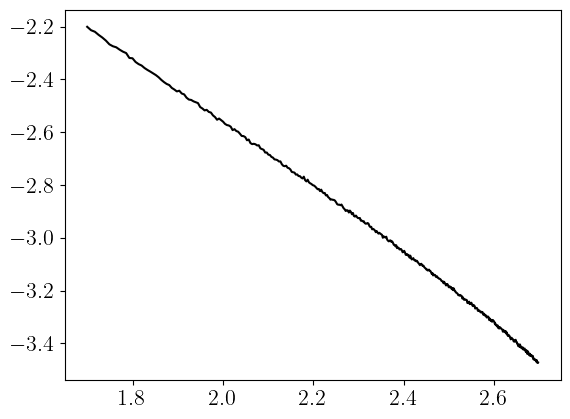

In [9]:
inertialleft = 50
inertialright = 500
inertialk = np.arange(inertialleft, inertialright)

plt.plot(np.log10(inertialk), np.ma.log10(tavg[inertialleft:inertialright]), color='k')


In [10]:
A = np.vstack([np.ma.log10(inertialk), np.ones(inertialk.size)]).T
m, c = np.linalg.lstsq(A, np.ma.log10(tavg[inertialleft:inertialright]))[0]
print([m, c])

[-1.2703435886195371, -0.016326540004317436]


/tmp/ipykernel_136406/4001170490.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, np.ma.log10(tavg[inertialleft:inertialright]))[0]


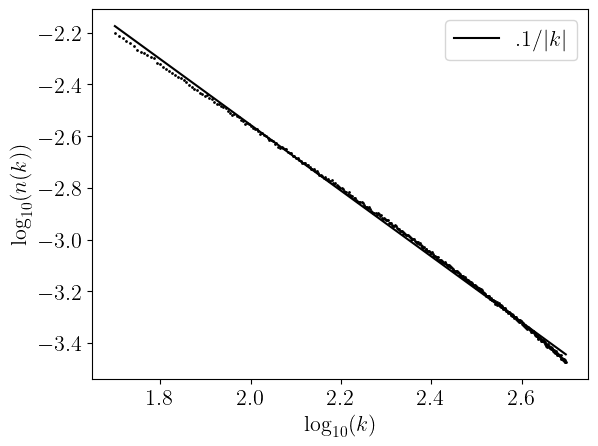

In [11]:
plt.scatter(np.ma.log10(inertialk), np.ma.log10(tavg[inertialleft:inertialright]), s=1.,color='k')
plt.plot(np.ma.log10(inertialk), np.ma.log10(10.**c * inertialk**(m)), color='k', label=r"$.1/|k|$")
plt.legend()
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(n(k))$")
plt.savefig("Equilibrium_Distribution_w_Fit.pdf", dpi=150, bbox_inches='tight')  

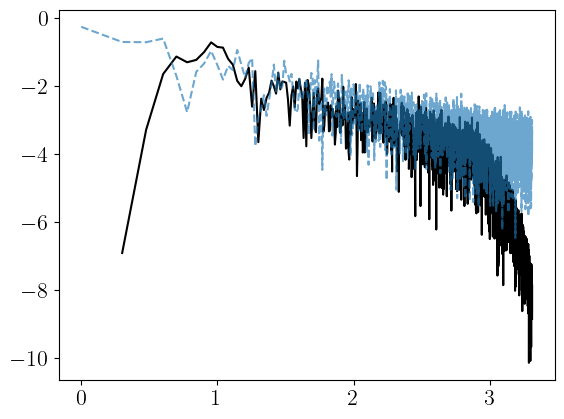

In [12]:
solclipped = np.abs(sol[:Nval])**2.
sol0clipped = np.abs(sol0[:Nval])**2.

kvals = np.arange(Nval)
#plt.plot(np.ma.log10(kvals[inertialleft:inertialright]), shift_scale_fft1[inertialleft:inertialright], color='k')#
#plt.plot(np.ma.log10(kvals[inertialleft:inertialright]), np.ma.log10(kvals**(-1.)), color='r')
#plt.plot(np.ma.log10(kvals[inertialleft:inertialright]), sol0clipped[inertialleft:inertialright], color='r', ls='--')

plt.plot(np.ma.log10(kvals), np.ma.log10(solclipped), color='k')
plt.plot(np.ma.log10(kvals), np.ma.log10(sol0clipped), ls='--', alpha=.65)


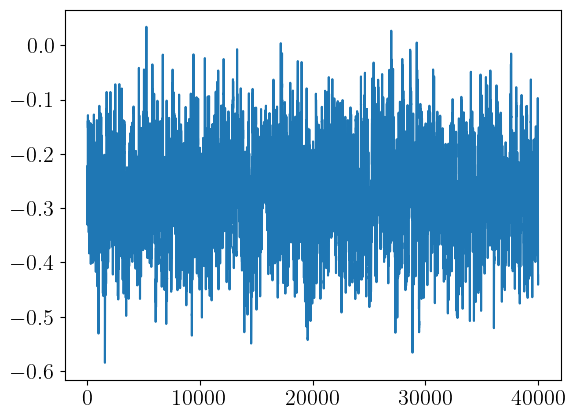

In [13]:
plt.plot(np.log10( hnonlinear[1:-1]/hlinear[1:-1] ))

In [14]:
inertialleft = 50
inertialright = 600
nmid_tstps = tseries_mid.shape[1]
taction_mid = np.abs(tseries_mid[:, :int(nmid_tstps/2.)])**2.
taction_long = np.abs(tseries)**2.

taction_mid[inertialright:-inertialright, :] = 0
taction_mid[:inertialleft, :] = 0
taction_mid[-inertialleft:, :] = 0

taction_long[inertialright:-inertialright, :] = 0
taction_long[:inertialleft, :] = 0
taction_long[-inertialleft:, :] = 0

#taction[inertialleft:inertialright, :] -= np.tile(tavg[inertialleft:inertialright].reshape(-1, 1), (1, taction.shape[1]))
#taction[-inertialright:-inertialleft, :] -= np.tile(tavg[inertialleft:inertialright][::-1].reshape(-1, 1), (1, taction.shape[1]))

# overlapping intervals
#lends = np.array([int(inertialleft), 
#                  int(inertialleft + .25*(inertialright-inertialleft)), 
#                  int(inertialleft + .5*(inertialright-inertialleft))])

#rends = np.array([int(inertialleft + .5*(inertialright-inertialleft)), 
#                  int(inertialleft + .75*(inertialright-inertialleft)), 
#                  int(inertialleft + .99*(inertialright-inertialleft))])

# nested intervals
#inertialright_clip = 500
#lends = np.array([int(inertialleft), 
#                  int(inertialleft), 
#                  int(inertialleft), 
#                  int(inertialleft)])

#rends = np.array([int(inertialleft + .2*(inertialright_clip-inertialleft)), 
#                  int(inertialleft + .4*(inertialright_clip-inertialleft)), 
#                  int(inertialleft + .6*(inertialright_clip-inertialleft)), 
#                  int(inertialleft + .8*(inertialright_clip-inertialleft))])


# disjoint intervals
inertialright_clip = 500
lends = np.array([int(inertialleft), 
                  int(inertialleft + .25*(inertialright_clip-inertialleft)), 
                  int(inertialleft + .5*(inertialright_clip-inertialleft)), 
                  int(inertialleft + .75*(inertialright_clip-inertialleft))])

rends = np.array([int(inertialleft + .25*(inertialright_clip-inertialleft)), 
                  int(inertialleft + .5*(inertialright_clip-inertialleft)), 
                  int(inertialleft + .75*(inertialright_clip-inertialleft)), 
                  int(inertialleft + (inertialright_clip-inertialleft))])

951
4001


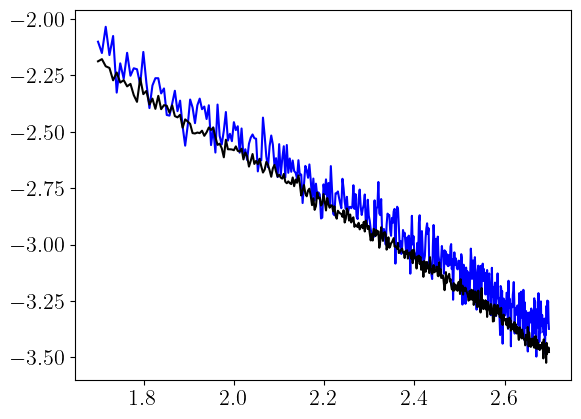

In [15]:
print(tseries_mid.shape[1])
print(tseries.shape[1])

shortsq = np.abs(tseries_short)**2.
mnsq_short = np.mean(shortsq, 1)

mnsq_mid = np.mean(taction_mid, 1)

plt.plot(np.log10(inertialk), np.log10(mnsq_short[inertialleft:inertialright_clip]), c='b')
plt.plot(np.log10(inertialk), np.log10(mnsq_mid[inertialleft:inertialright_clip]), c='k')


In [16]:
def scale_sep_correlation_and_et_graph(tseries, dts, ep_val, avgscl, dep_fac, stp_range, kneighbor, lends, rends):
    
    multiscale_sep, tskip = wwt.scale_sep_and_downsampling(tseries, dts, ep_val, avgscl, inertialleft, inertialright, lends, rends)
    mscl_sep_dep = multiscale_sep[:, ::dep_fac]
    mscl_sep_dep = wwt.zero_average_scale(mscl_sep_dep)
    dts_fine = dts * dep_fac
    return mscl_sep_dep, dts_fine

In [17]:
def information_comp(mscl_sep_dep, stp_range, kneighbor):
    ndim = mscl_sep_dep.shape[0]    
    osteps_it = np.zeros((ndim, stp_range), dtype=np.float64)
    for jj in range(ndim):
        for ll in range(1, stp_range+1):
            forward = mscl_sep_dep[jj, ll:].reshape(-1,1)
            backward = mscl_sep_dep[jj, :-ll].reshape(-1,1)                    
            osteps_it[jj, ll-1] = mi.miknn(forward, backward, kneighbor)
                
    return osteps_it

In [18]:
def scale_sep_plot(multiscale_sep, dts_local, init, tag):
    taxis = init + dts_local*np.arange(multiscale_sep.shape[1])
    plt.figure(figsize=(8, 6))
    colors = ['k', 'r', 'b', 'g']
    for ll in range(multiscale_sep.shape[0]):
        title = r"$F_{" + str(ll) + "}(t)$"
        plt.plot(taxis, multiscale_sep[ll, :], c=colors[ll], ls='-', label=title)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$F_{j}(t)$")
    plt.legend()
    plt.savefig(f"F_plots"+tag+".pdf", dpi=150, bbox_inches='tight') 


def ac_corr_sep_plot(multiscale_sep, dts_fine, tag):
    skp = 0
    taxis = dts_fine*np.arange(multiscale_sep.shape[1])
        
    nlags = int(multiscale_sep.shape[1]/2)
    plt.figure(figsize=(8, 6)) 
    acf_result = acf(multiscale_sep[0, skp:-1], nlags=nlags)
    colors=['k', 'r', 'b', 'g']
    for ll in range(len(colors)):
        title = r"$F_{" + str(ll) + "}(t)$"
        plt.plot(taxis[:nlags+1], acf(multiscale_sep[ll, skp:-1], nlags=nlags), color=colors[ll], label=title)
    pvbar = 1.96/np.sqrt(np.size(np.array(acf_result)))
    plt.plot(taxis[:nlags+1], pvbar*np.ones(len(acf_result)), color='b', ls='--')
    plt.plot(taxis[:nlags+1], -pvbar*np.ones(len(acf_result)), color='b', ls='--')

    plt.xlabel(r"$t$")
    plt.ylabel(r"$ACF(F_{j}(t))$")
    plt.legend()
    plt.savefig(f"ACF_plots"+tag+".pdf", dpi=150, bbox_inches='tight') 

Current time step is: 2.0


/tmp/ipykernel_136406/350277636.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  multiscale_sep_force[jj, :] = np.mean(taction_avg_force[lends[jj]:rends[jj], :], 0)
/home/ccurtis/Desktop/onr_signal_processing_project/wwt_code_and_figures/wwt_tools.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  trscl[kk, :] = (tseries[kk, :]-tavg[kk])/var
/tmp/ipykernel_136406/350277636.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  multiscale_sep_short[jj, :] = np.mean(taction_avg_short[lends[jj]:rends[jj], :], 0)
/tmp/ipykernel_136406/350277636.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  multiscale_sep_long[jj, :] = np.mean(taction_avg_long[lends[jj]:rends[jj], :], 0)


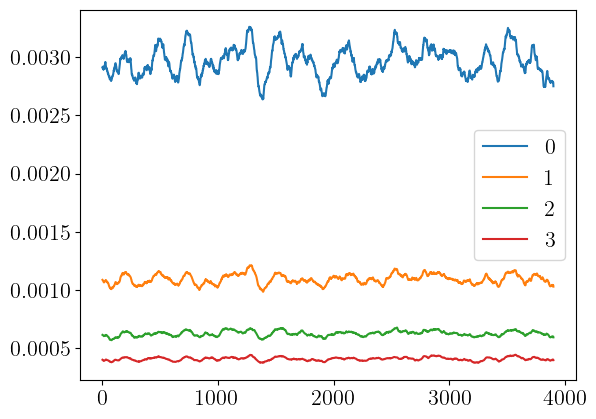

In [19]:
# to be used on longer time series 
tskip_force = int(10/ep_val**2. * 1./dts)
tskip_short = int(50/ep_val**2. * 1./dts)
tskip_long = int(500/ep_val**2. * 1./dts)
stp = 20
print(f"Current time step is: {dts}")

taction_avg_force = wwt.window_time_average(taction_long, tskip_force)
taction_avg_short = wwt.window_time_average(taction_long, tskip_short)
taction_avg_long = wwt.window_time_average(taction_long, tskip_long)

multiscale_sep_force = np.zeros((lends.size, taction_avg_force.shape[1]), dtype=np.float64)
multiscale_sep_force_za = np.zeros((lends.size, taction_avg_force.shape[1]), dtype=np.float64)

multiscale_sep_short = np.zeros((lends.size, taction_avg_short.shape[1]), dtype=np.float64)
multiscale_sep_short_za = np.zeros((lends.size, taction_avg_short.shape[1]), dtype=np.float64)

multiscale_sep_long = np.zeros((lends.size, taction_avg_long.shape[1]), dtype=np.float64)
multiscale_sep_long_za = np.zeros((lends.size, taction_avg_long.shape[1]), dtype=np.float64)

for jj in range(lends.size):
    multiscale_sep_force[jj, :] = np.mean(taction_avg_force[lends[jj]:rends[jj], :], 0)
    multiscale_sep_force_za[jj, :] = np.mean(wwt.zero_average_scale(taction_avg_force[lends[jj]:rends[jj], :]), 0)

    multiscale_sep_short[jj, :] = np.mean(taction_avg_short[lends[jj]:rends[jj], :], 0)
    multiscale_sep_short_za[jj, :] = np.mean(wwt.zero_average_scale(taction_avg_short[lends[jj]:rends[jj], :]), 0)
    
    multiscale_sep_long[jj, :] = np.mean(taction_avg_long[lends[jj]:rends[jj], :], 0)
    multiscale_sep_long_za[jj, :] = np.mean(wwt.zero_average_scale(taction_avg_long[lends[jj]:rends[jj], :]), 0)

for jj in range(lends.size):
    plt.plot(multiscale_sep_short[jj, :], label=str(jj))
plt.legend()

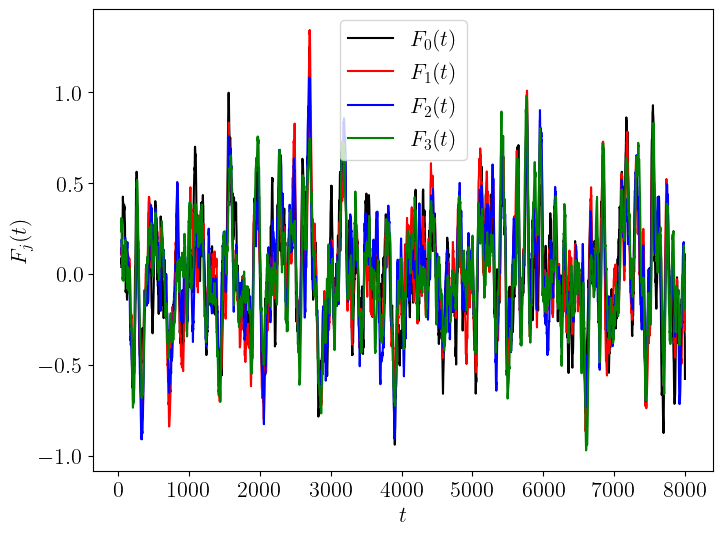

In [20]:
scale_sep_plot(multiscale_sep_force_za, dts, 10./ep_val**2., "_force")

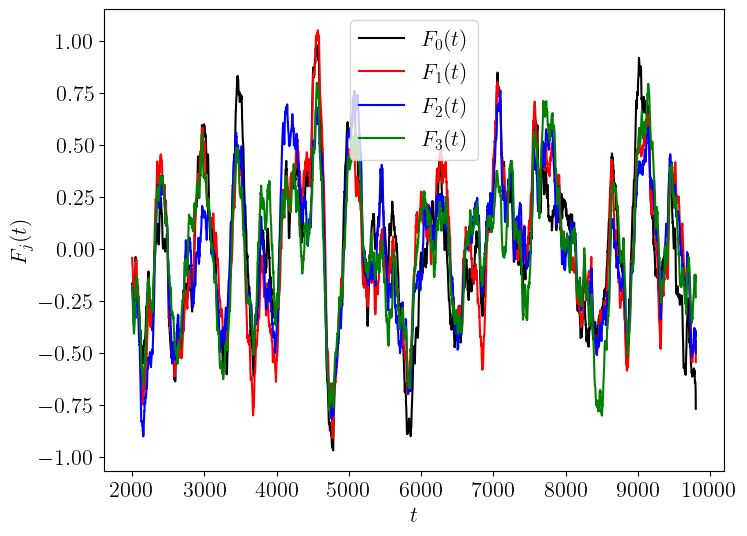

In [21]:
scale_sep_plot(multiscale_sep_short_za, dts, 500./ep_val**2., "_short")

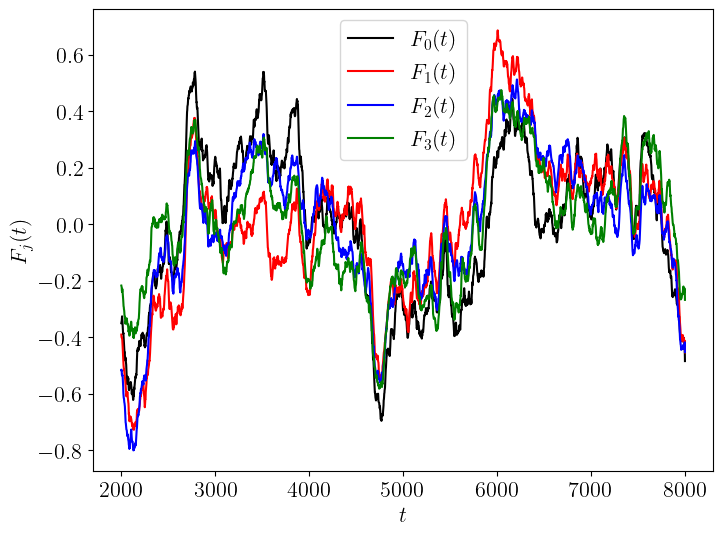

In [22]:
scale_sep_plot(multiscale_sep_long_za, dts, 500./ep_val**2., "_long")

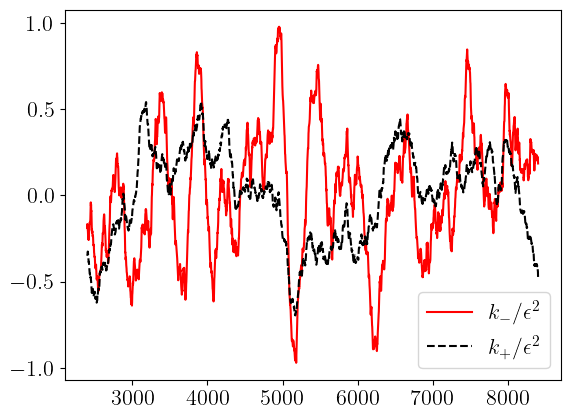

In [23]:
init = inertialright/ep_val**2.

taxis_short = init + dts*np.arange(multiscale_sep_short_za.shape[1])
taxis_long = init + dts*np.arange(multiscale_sep_long_za.shape[1])    
plt.plot(taxis_long, multiscale_sep_short_za[0, :taxis_long.size], c='r', label=r'$k_{-}/\epsilon^{2}$')
plt.plot(taxis_long, multiscale_sep_long_za[0, :], c='k', ls='--', label=r'$k_{+}/\epsilon^{2}$')
plt.legend()
plt.savefig(f"F0_plots.pdf", dpi=150) 

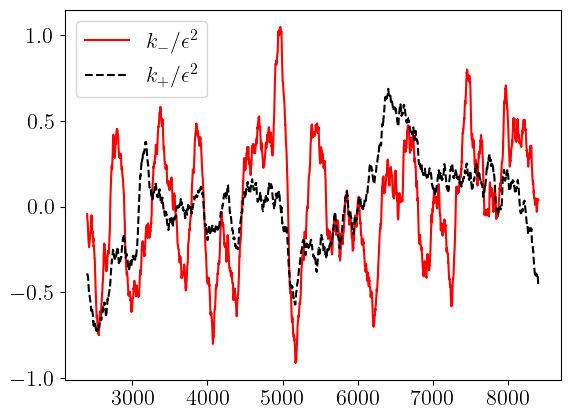

In [24]:
plt.plot(taxis_long, multiscale_sep_short_za[1, :taxis_long.size], c='r', label=r'$k_{-}/\epsilon^{2}$')
plt.plot(taxis_long, multiscale_sep_long_za[1, :], c='k', ls='--', label=r'$k_{+}/\epsilon^{2}$')
plt.legend()
plt.savefig(f"F1_plots.pdf", dpi=150) 

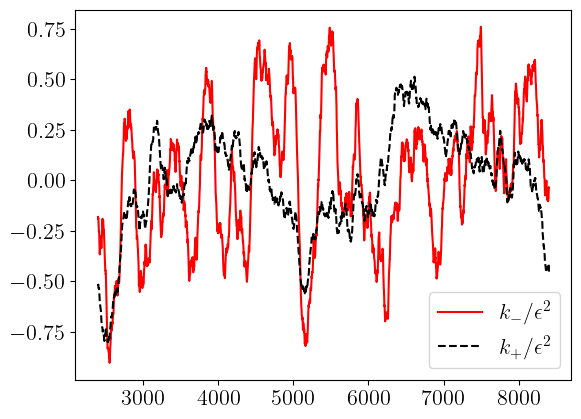

In [25]:
plt.plot(taxis_long, multiscale_sep_short_za[2, :taxis_long.size], c='r', label=r'$k_{-}/\epsilon^{2}$')
plt.plot(taxis_long, multiscale_sep_long_za[2, :], c='k', ls='--', label=r'$k_{+}/\epsilon^{2}$')
plt.legend()
plt.savefig(f"F2_plots.pdf", dpi=150) 

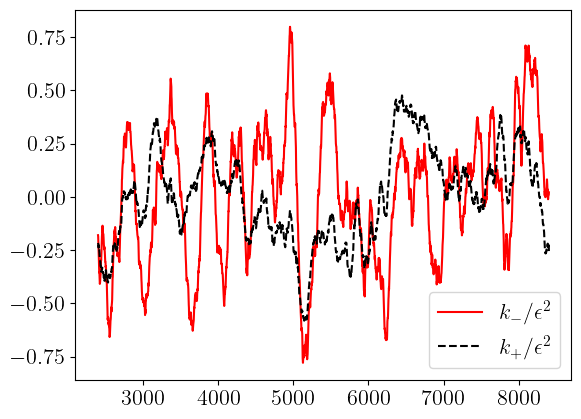

In [26]:
plt.plot(taxis_long, multiscale_sep_short_za[3, :taxis_long.size], c='r', label=r'$k_{-}/\epsilon^{2}$')
plt.plot(taxis_long, multiscale_sep_long_za[3, :], c='k', ls='--', label=r'$k_{+}/\epsilon^{2}$')
plt.legend()
plt.savefig(f"F3_plots.pdf", dpi=150) 

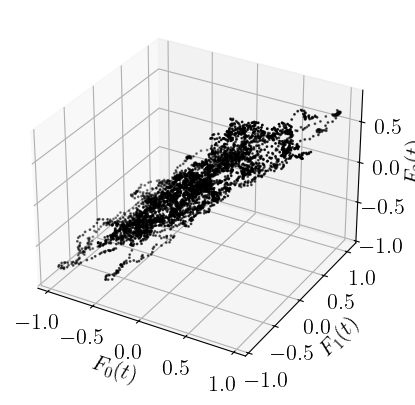

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(multiscale_sep_short_za[0, :], multiscale_sep_short_za[1, :], multiscale_sep_short_za[2, :], s=1., c='k')
ax.set_xlabel(r"$F_{0}(t)$")
ax.set_ylabel(r"$F_{1}(t)$")
ax.set_zlabel(r"$F_{2}(t)$")
plt.savefig(f"F_plots_short_average_012.pdf", dpi=150) 

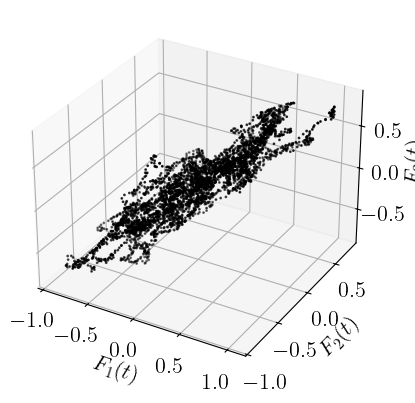

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(multiscale_sep_short_za[1, :], multiscale_sep_short_za[2, :], multiscale_sep_short_za[3, :], s=1., c='k')
ax.set_xlabel(r"$F_{1}(t)$")
ax.set_ylabel(r"$F_{2}(t)$")
ax.set_zlabel(r"$F_{3}(t)$")
plt.savefig(f"F_plots_short_average_123.pdf", dpi=150, bbox_inches='tight') 

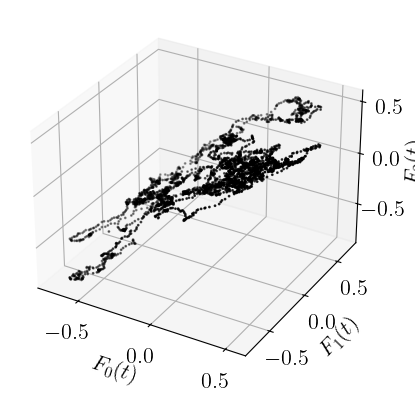

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(multiscale_sep_long_za[0, :], multiscale_sep_long_za[1, :], multiscale_sep_long_za[2, :], s=1., c='k')
ax.set_xlabel(r"$F_{0}(t)$")
ax.set_ylabel(r"$F_{1}(t)$")
ax.set_zlabel(r"$F_{2}(t)$")
plt.savefig(f"F_plots_long_average_012.pdf", dpi=150, bbox_inches='tight') 

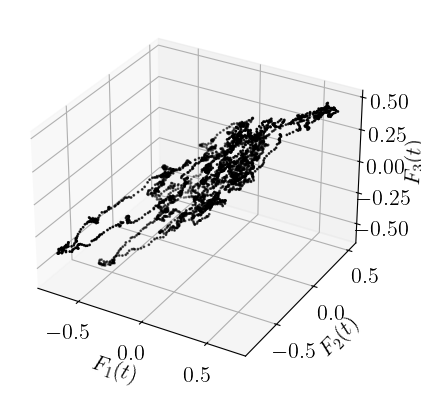

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(multiscale_sep_long_za[1, :], multiscale_sep_long_za[2, :], multiscale_sep_long_za[3, :], s=1., c='k')
ax.set_xlabel(r"$F_{1}(t)$")
ax.set_ylabel(r"$F_{2}(t)$")
ax.set_zlabel(r"$F_{3}(t)$")
plt.savefig(f"F_plots_long_average_123.pdf", dpi=150, bbox_inches='tight') 

In [31]:
kneighbor=3
osteps_short_za = information_comp(multiscale_sep_short_za, stp, kneighbor)
osteps_long_za = information_comp(multiscale_sep_long_za, stp, kneighbor)

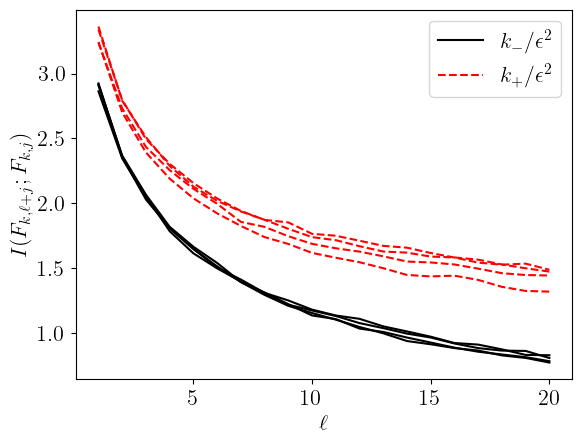

In [32]:
lags = np.arange(1, stp+1)
for ll in range(4):
    if ll==0:
        plt.plot(lags, osteps_short_za[ll, :], c='k', label=r'$k_{-}/\epsilon^{2}$')
        plt.plot(lags, osteps_long_za[ll, :], c='r', ls='--', label=r'$k_{+}/\epsilon^{2}$')   
    else:
        plt.plot(lags, osteps_short_za[ll, :], c='k')
        plt.plot(lags, osteps_long_za[ll, :], c='r', ls='--')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$I(F_{k, \ell+j};F_{k, j})$")
plt.legend()
plt.savefig(f"MMT_lag_test_"+str(stp)+".pdf", dpi=150, bbox_inches='tight') 

In [46]:
alpha_m = .05
max_lag = 5

In [47]:
# WWT time regime, fast averaging
results_short = my_ceb.Model_Graph(data=multiscale_sep_short_za, max_lag=max_lag, 
                                  kneighbor=kneighbor, alpha_m=alpha_m)
results_short.et_graph_model_builder()
pickle.dump(results_short, open("results_short_max_lag_"+str(max_lag)+".pkl", "wb"))

For target 0
Target model: [1, 3]
Chosen sources: [[2, 3, 1]]
Final information content of model: 0.22680686438620568

For target 1
Target model: [1, 3]
Chosen sources: [[2, 3, 1], [3, 2, 0]]
Final information content of model: 0.24531466312430472

For target 2
Target model: [1, 5]
Chosen sources: [[2, 3, 1], [3, 2, 0], [0, 1, 3]]
Final information content of model: 0.22596173401668995

For target 3
Target model: [1, 3]
Chosen sources: [[2, 3, 1], [3, 2, 0], [0, 1, 3], [0, 1, 2]]
Final information content of model: 0.23137850943418514



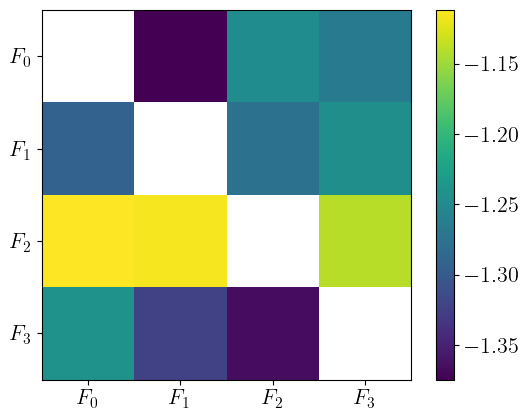

In [48]:
results_short.mat_visualizer(results_short.source_info_mat, 'F', True, 'viridis')
plt.savefig("MMT_short_source_info_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

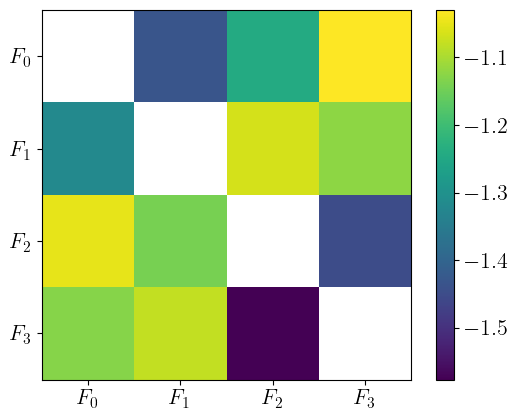

In [49]:
results_short.mat_visualizer(results_short.te_mat, 'F', True, 'viridis')
plt.savefig("MMT_short_te_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

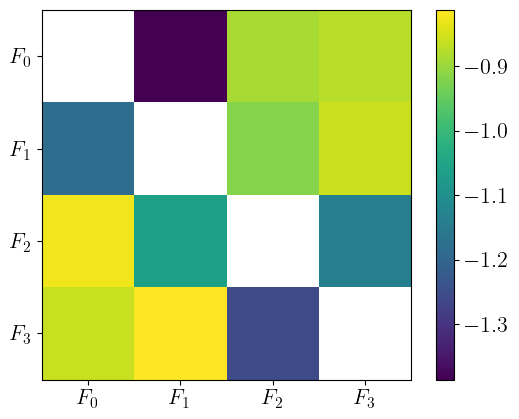

In [50]:
results_short.mat_visualizer(results_short.it_mat, 'F', True, 'viridis')
plt.savefig("MMT_short_it_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

In [51]:
# WWT time regime
results_long = my_ceb.Model_Graph(data=multiscale_sep_long_za, max_lag=max_lag, 
                                  kneighbor=kneighbor, alpha_m=alpha_m)
results_long.et_graph_model_builder()

For target 0
Target model: [1, 4]
Chosen sources: [[1, 3]]
Final information content of model: 0.21384770729467673

For target 1
Target model: [1, 4]
Chosen sources: [[1, 3], [3, 0]]
Final information content of model: 0.20393745793098395

For target 2
Target model: [1, 4]
Chosen sources: [[1, 3], [3, 0], [0, 1]]
Final information content of model: 0.20630905192782256

For target 3
Target model: [1, 5]
Chosen sources: [[1, 3], [3, 0], [0, 1], [0, 1]]
Final information content of model: 0.204627822250381



In [52]:
pickle.dump(results_long, open("results_long_max_lag_"+str(max_lag)+".pkl", "wb"))

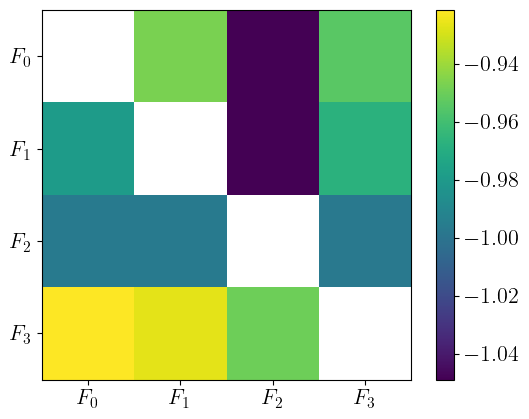

In [53]:
results_long.mat_visualizer(results_long.source_info_mat, 'F', True, 'viridis')
plt.savefig("MMT_long_source_info_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

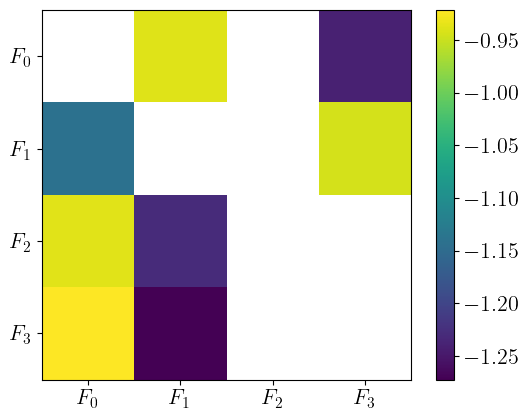

In [54]:
results_long.mat_visualizer(results_long.te_mat, 'F', True, 'viridis')
plt.savefig("MMT_long_te_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

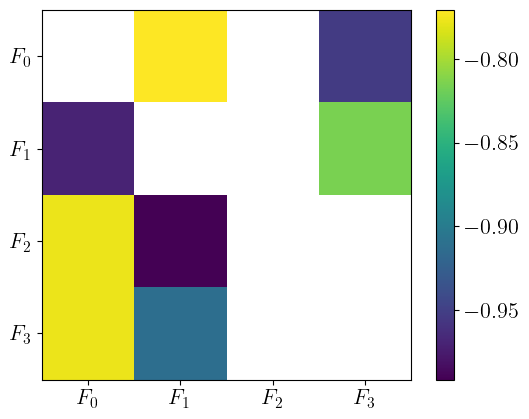

In [55]:
results_long.mat_visualizer(results_long.it_mat, 'F', True, 'viridis')
plt.savefig("MMT_long_it_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

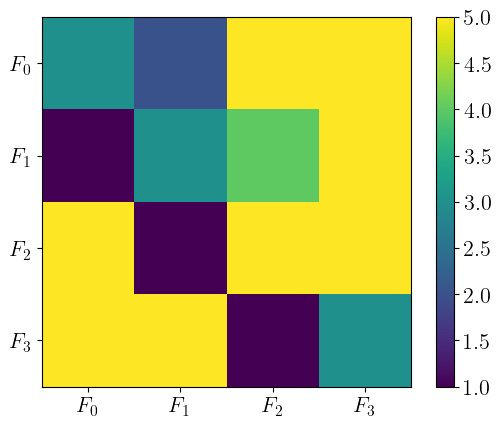

In [56]:
lag_matrix_short = np.zeros((4, 4), dtype=int)
for cnt, target in enumerate(results_short.target_models):
    lag_matrix_short[cnt, cnt] = max(target.model)

all_original_indices = results_short.chosen_sources_original_indices
all_original_target_indices = results_short.chosen_sources_for_target
    
for cnt, best_e_graph in enumerate(results_short.source_models):
    my_original_source_indices = all_original_indices[cnt]
    my_original_target_index = all_original_target_indices[cnt]        
    for next_cnt, source_label in enumerate(best_e_graph.chosen_sources):
        #original_index = my_original_indices[source_label]
        lag_matrix_short[my_original_target_index, my_original_source_indices[next_cnt]] = max(best_e_graph.sources[source_label].model)

results_short.mat_visualizer(lag_matrix_short, 'F', False, 'viridis')
plt.savefig("MMT_short_lags_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

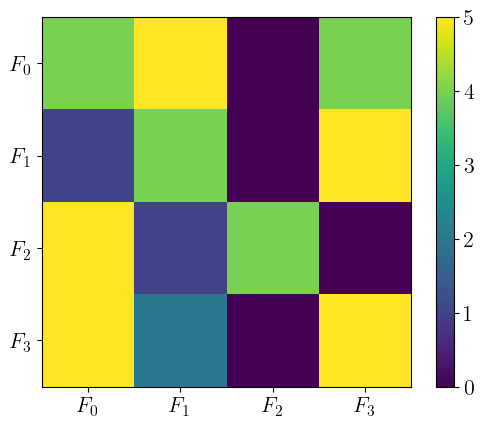

In [57]:
lag_matrix_long = np.zeros((4, 4), dtype=int)
for cnt, target in enumerate(results_long.target_models):
    lag_matrix_long[cnt, cnt] = max(target.model)

all_original_indices = results_long.chosen_sources_original_indices
all_original_target_indices = results_long.chosen_sources_for_target

for cnt, best_e_graph in enumerate(results_long.source_models):
    my_original_source_indices = all_original_indices[cnt]
    my_original_target_index = all_original_target_indices[cnt]        
    for next_cnt, source_label in enumerate(best_e_graph.chosen_sources):
        #original_index = my_original_indices[source_label]
        lag_matrix_long[my_original_target_index, my_original_source_indices[next_cnt]] = max(best_e_graph.sources[source_label].model)

results_long.mat_visualizer(lag_matrix_long, 'F', False, 'viridis')
plt.savefig("MMT_long_lags_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  